## Introduction

The goal for this project is to create a visualisation and prepare a write up describing the similarities and differences between global temperature trends and temperature trends in the closest big city to where I live.

I choose to use Python to do the exploratory data analysis of temperature trends. 

First, import the libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sympy

As I live in the UK and the closest city to me is London, I am interested to see how temperatures in London vary over the years compared against the global average. The SQL query used to retrive this information is below:

In [2]:
'''
SELECT c.year yc, c.avg_temp tc,
	   g.year yg, g.avg_temp tg 
FROM city_data AS c 
INNER JOIN global_data AS g 
ON c.year = g.year 
WHERE c.city = 'London' and c.country = 'United Kingdom'
''';

## Import and Review Data

Import the csv file that was created from the SQL task. 

Also make some tweaks around the headings of the columns to provide more clarity for the analysis later.

In [3]:
df = pd.read_csv('Extracted temperatures.csv', 
                 header=0,
                 usecols=[0, 1, 3],
                 names=['year', 't_London', 't_global'])
df.head()

,year,t_London,t_global
0,1750,10.25,8.72
1,1751,9.99,7.98
2,1752,6.54,5.78
3,1753,9.42,8.39
4,1754,9.20,8.47


Take a look at the dataframe: check if the entries are numerical and check for any missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      264 non-null    int64  
 1   t_London  264 non-null    float64
 2   t_global  264 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 6.3 KB


In [5]:
min_year, max_year = df['year'].min(), df['year'].max()
min_year, max_year

(1750, 2013)

## Data Pre-processing and Visualisation

Calculate the moving average using .rolling() in pandas - take a moving window of 10 years:

In [6]:
window = 10

df['moving_avg_London'] = df['t_London'].rolling(window).mean()
df['moving_avg_global'] = df['t_global'].rolling(window).mean()

df.head(10)

,year,t_London,t_global,moving_avg_London,moving_avg_global
0,1750,10.25,8.72,NaN,NaN
1,1751,9.99,7.98,NaN,NaN
2,1752,6.54,5.78,NaN,NaN
3,1753,9.42,8.39,NaN,NaN
4,1754,9.20,8.47,NaN,NaN
5,1755,8.95,8.36,NaN,NaN
6,1756,9.42,8.85,NaN,NaN
7,1757,9.34,9.02,NaN,NaN
8,1758,8.85,6.74,NaN,NaN
9,1759,9.80,7.99,9.176,8.03


Drop the rows with NaN - the first years on their own will not be used for plot

In [7]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,year,t_London,t_global,moving_avg_London,moving_avg_global
0,1759,9.80,7.99,9.176,8.030
1,1760,9.26,7.19,9.077,7.877
2,1761,9.69,8.77,9.047,7.956
3,1762,8.99,8.61,9.292,8.239
4,1763,8.75,7.50,9.225,8.150


Now make a line plot to compare the moving average temperatures

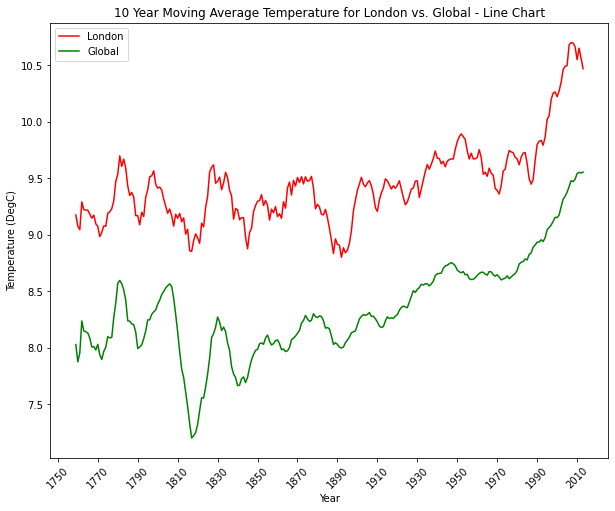

In [8]:
plt.figure(figsize=(10,8))

plt.plot(df['year'], df['moving_avg_London'], c='r', label='London')
plt.plot(df['year'], df['moving_avg_global'], c='g', label='Global')

plt.title('10 Year Moving Average Temperature for London vs. Global - Line Chart')
plt.xlabel('Year')
plt.xticks(np.arange(1750, 2015, 20), rotation=45)
plt.ylabel('Temperature (DegC)')
plt.legend(loc='best')

plt.show()

London is surprisingly 'hot' given that its temperatures are clearly above the global average. This is definitely not my impression of the British cold weather!

I also notice that there are some interesting peaks at around 1780s - this may be attributed to the Industrial Revolution.

On the other hand, there are also some eye-catching troughs over the first half of 19th century - this may be attributed to the Cholera pandemic. In those years there were a few massive waves of contagious disease including the influenza epidemics. The diseases significantly reduced human activities and hence lowered the global temperatures (much similar to the most recent Coronavirus outbreak).

Another observation from the plot is that the temperature is trending upwards as time goes for both London and the global average.

## Insight - Statistical Analysis

One might ask how much hotter is London than the global average? Let's first have a look at some statistics.

In [9]:
df[['t_London', 't_global', 'moving_avg_London', 'moving_avg_global']].describe()

,t_London,t_global,moving_avg_London,moving_avg_global
count,255.000000,255.000000,255.000000,255.000000
mean,9.472196,8.370863,9.450353,8.344286
std,0.650204,0.549648,0.370030,0.440769
min,7.620000,6.780000,8.802000,7.203000
25%,9.060000,8.085000,9.203000,8.053000
50%,9.430000,8.360000,9.415000,8.274000
75%,9.880000,8.700000,9.620500,8.636500
max,11.190000,9.730000,10.701000,9.556000


In [10]:
xbar_London = df['moving_avg_London'].mean()
xbar_global = df['moving_avg_global'].mean()
mean_diff = xbar_London - xbar_global
mean_diff

1.1060666666666599

In [11]:
percent_hotter = (xbar_London - xbar_global) / xbar_global
percent_hotter

0.13255377755260878

So the moving average temperatures of London is roughly 13% (~1.1 DegC) higher than that across the globe between 1750 and 2013. But this is for a 264-year sample of all time. Let's just see the estimated spread of sample means across all time for London and the global average - take a 95% confidence interval of the difference between means.

In [12]:
cm = sms.CompareMeans(sms.DescrStatsW(df['moving_avg_London']), 
                      sms.DescrStatsW(df['moving_avg_global']))
lcd, ucd = cm.tconfint_diff(usevar='unequal')
lcd, ucd

(1.0352574724952124, 1.1768758608381145)

Therefore, supported by evidence from the plot and from the calculated statistics, we are reasonably confident to say that the temperatures in London is about 1 DegC higher than the global average.

Since the plot shows that the temperature is trending upwards as time goes for both London and the global average, let's see the correlations against time.

In [13]:
corr_London = stats.spearmanr(df['moving_avg_London'], df['year'])
corr_global = stats.spearmanr(df['moving_avg_global'], df['year'])
corr_London, corr_global

(SpearmanrResult(correlation=0.6869482336093713, pvalue=6.0947676738124995e-37),
 SpearmanrResult(correlation=0.7583457767610071, pvalue=6.289497395329186e-49))

So we are confident (as p-values are extremely low for a reasonable size dataset) that there are positive correlations between the temperatures and time.

How about the difference in temperatures between London and the global average? Is this also increasing (meaning London is getting hotter faster than the world average)? The plot isn't that clear in this perspective, so we will need to find out the correlation between difference in temperatures and the time.

In [14]:
diff_t = df['moving_avg_London'] - df['moving_avg_global']
corr_diff = stats.spearmanr(diff_t, df['year'])
corr_diff

SpearmanrResult(correlation=-0.3807980395969675, pvalue=3.184106323432312e-10)

So there is in fact a drop in temperature difference between London and the global average, in other words, the increase in global temperature is catching up with that in London, although London has so far taken a lead of around 1 DegC.

Let's visualise the correlation between the recorded global and London temperatures:

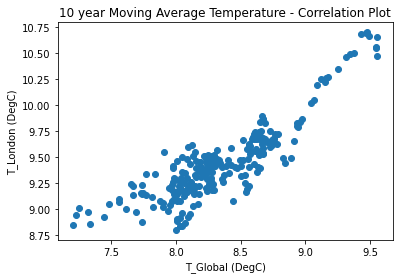

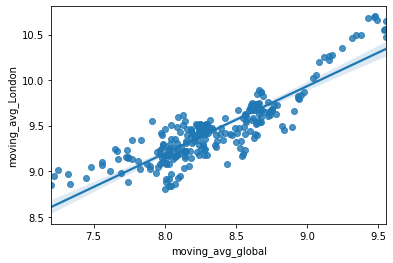

In [15]:
plt.scatter(df['moving_avg_global'], df['moving_avg_London'])

plt.title('10 year Moving Average Temperature - Correlation Plot')
plt.xlabel('T_Global (DegC)')
plt.ylabel('T_London (DegC)')

plt.show()

sns.regplot(x=df['moving_avg_global'], y=df['moving_avg_London']);

Obviously, there should be a positive correlation between the global and London temperature trends:

In [16]:
stats.spearmanr(df['moving_avg_London'], df['moving_avg_global'])

SpearmanrResult(correlation=0.8457130171367704, pvalue=5.827402642200563e-71)

### Summary

The temperatures in London is consistently higher (>= 1 DegC) than the global average. And although both London and global teperatures have been creeping up over the past few hudreads of years, the gap between the two is closing in. There is in fact a drop in temperature difference between London and the global average over the recent years, in other words, the increase in global temperature is catching up with that in London, although London has so far taken a lead of around 1 DegC.

## Insight - Building a Model

The above findings suggest that we can use a linear regression model to approximate the relationship between the two temperatures. Use a test size of 20% of the data and see how the linear model performs.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df[['moving_avg_global']], df['moving_avg_London'], 
                                                    test_size=0.2, 
                                                    random_state=1)

In [18]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [19]:
yhat = lm.predict(X_test)
r2_score(y_test, yhat)

0.7301745491797308

### Summary

An R-Squared score of 0.73 isn't too bad for a single-feature linear regression model. So let's see the linear equation that we can use to approximate London's temperature using the global average (which represents the line in the regplot above). Note that this is a very ideal approximation.

$t_{Lond} = w * t_{glob} + b$

In [20]:
w, b = lm.coef_, lm.intercept_
t_glob, t_Lond = sympy.symbols('t_glob t_Lond')
t_Lond = w * t_glob + b
print(t_Lond)

[0.744235885159557*t_glob + 3.24487084950549]


Thanks for reading through my work. Please kindly leave your feedback.

Minjian